In [1]:
import os

import ipywidgets as widgets
import numpy as np
import pandas as pd
import scipy.sparse
from IPython.display import display
from ipywidgets import interact
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
import os
# alternatively, you may override the variables in oneinamillion.resources.py
os.environ['PCC_BASE_DIR'] = "Z:/"

In [3]:
from oneinamillion.resources import PCC_BASE_DIR
print(f"RDSF base directory located at {PCC_BASE_DIR}")

RDSF base directory located at Z:/


In [4]:
from oneinamillion.pc_consultation import PCConsultation

parser = PCConsultation()  # the only class needed to obtain all PC consultation data-pairs
orig_dataset = parser.get_pd()

# orig_dataset.head()  # uncomment to inspect the original dataset

The current IDs only have record documents.
['011119' '020105' '030311' '030501' '030509' '030510' '050609' '050717'
 '050719' '071010' '071201' '071202' '071203' '071204' '071205' '071206'
 '071207' '071208' '071209' '071210' '071211' '071212' '071213' '071214'
 '081310' '081608' '081610' '091410' '091411' '091416' '101705' '101707'
 '111906' '111908' '112004' '122110']
The current IDs only have transcript documents.
['-081308' '010103' '010105' '020107' '030501(p.2)' '030501(p1)'
 '030509(p.1)' '030509(p.2)' '030510 (p.1)' '030510 (p.2)' '040417'
 '050605' '050609a' '050717 (Dr reads wrong number)' '060806' '060811'
 '060812' '060906' '071002' '071010(a)' '071012' '081310(b)' '081310(c)'
 '081310a' '081601' '081606' '081608 (1 of 2)' '081608 (2 of 2)' '091402'
 '091404' '091405' '091410 & 091411' '091503' '101705 and 101707' '101801'
 '111906 (2of2)' '111906(1 of 2)' '112002' '112004 & 1112005' '112014'
 '200105' '50719']


# Data preparation

First split the orig_dataset into train and test set, then we need to
pre-process the transcript data

This includes, cleaning text, stemming and lemmatization

In [5]:
from utils.preprocessing.data import extract_icpc_categories
from utils.transcripts import preprocess_transcripts, read_transcript

orig_dataset['codes'] = orig_dataset['icpc_codes'].apply(extract_icpc_categories)
orig_dataset['transcript__conversation_clean'] = orig_dataset['transcript__conversation'].apply(preprocess_transcripts)
orig_dataset['transcript__conversation_both'] = orig_dataset['transcript__conversation_clean'].apply(
    lambda t: read_transcript(t, return_format='concat'))
orig_dataset['transcript__conversation_gp'] = orig_dataset['transcript__conversation_clean'].apply(
    lambda t: read_transcript(t, show_gp=True, show_patient=False, return_format='concat'))
orig_dataset['transcript__conversation_patient'] = orig_dataset['transcript__conversation_clean'].apply(
    lambda t: read_transcript(t, show_gp=False, show_patient=True, return_format='concat'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dotvi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
#orig_dataset.head()

In [7]:
#orig_dataset.info()

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

y = orig_dataset['codes']
mult_lbl_enc = MultiLabelBinarizer()
y_hot = mult_lbl_enc.fit_transform(y)
print(f"{len(mult_lbl_enc.classes_)} classification categories: {mult_lbl_enc.classes_}")

16 classification categories: ['A' 'B' 'D' 'F' 'H' 'K' 'L' 'N' 'P' 'R' 'S' 'T' 'U' 'W' 'X' 'Y']


## Train test Split

In [9]:
from skmultilearn.model_selection import iterative_train_test_split

X = np.arange(orig_dataset['index'].shape[0]).reshape((-1, 1))

X_train, y_train, X_test, y_test = iterative_train_test_split(X, y_hot, test_size=0.2)

train_set = orig_dataset.iloc[X_train.flatten()]
test_set = orig_dataset.iloc[X_test.flatten()]
#train_set.head()

## ICPC descriptions

In [10]:
from oneinamillion.clinical_codes.icpc import IcpcParser

icpc_parser = IcpcParser()
icpc_df = icpc_parser.get_pd()

In [11]:
from utils.preprocessing.text import utils_preprocess_text

icpc_df['cat'] = icpc_df['Code'].astype('string').apply(lambda x: x[0].upper())

clean_col = lambda x: utils_preprocess_text(x) if not pd.isna(x) else x
# building keyword collection from three columns of the ICPC-2 descriptions
icpc_df['criteria_prepared'] = icpc_df['criteria'].apply(clean_col)
icpc_df['inclusion_prepared'] = icpc_df['inclusion'].apply(clean_col)
icpc_df['preferred_prepared'] = icpc_df['preferred'].apply(clean_col)
icpc_df['keywords'] = icpc_df[['preferred_prepared', 'criteria_prepared', 'inclusion_prepared']].fillna('').agg(
    ' '.join, axis=1)

In [12]:
icpc_description_corpus = icpc_df[['cat', 'keywords']].groupby('cat').agg(' '.join).iloc[1:-1]
icpc_description_corpus.index.name = None
icpc_description_corpus

,keywords
A,pain general/multiple site chronic general pa...
B,lymph gland(s) enlarged/painful lymphadenopat...
D,abdominal pain/cramps general abdominal colic...
F,eye pain red eye bloodshot/inflamed eye eye...
H,ear pain/earache hearing complaint auditory...
K,heart pain pain attributed heart pressure/tig...
L,neck symptom/complaint pain attributed cervic...
N,headache post-traumatic headache pain face ...
P,feeling anxious/nervous/tense feeling reported...
R,pain respiratory system painful respiration; ...


In [13]:
print(f"dataset categories: {np.array(mult_lbl_enc.classes_).astype('str')}")
print(f"icpc descriptions:  {np.array(icpc_description_corpus.index).astype('str')}")

dataset categories: ['A' 'B' 'D' 'F' 'H' 'K' 'L' 'N' 'P' 'R' 'S' 'T' 'U' 'W' 'X' 'Y']
icpc descriptions:  ['A' 'B' 'D' 'F' 'H' 'K' 'L' 'N' 'P' 'R' 'S' 'T' 'U' 'W' 'X' 'Y']


In [14]:
# Integrate with CKS descriptions
from oneinamillion.clinical_codes.cks import CksParser

# use from_raw to refresh cached cks descriptions, and headings_to_include to use different set of sub-sections to include
cks_parser = CksParser()
cks_description_corpus = cks_parser.get_pd()
#cks_description_corpus

In [15]:
selected_mode = None
modes = ['ICPC only', 'CKS only', 'ICPC and CKS']
def control_description(mode=modes[2]):
    global selected_mode
    selected_mode = mode

interact(control_description, mode=modes)

interactive(children=(Dropdown(description='mode', index=2, options=('ICPC only', 'CKS only', 'ICPC and CKS'),…

<function __main__.control_description(mode='ICPC and CKS')>

In [16]:
print(f"Description: {selected_mode}")
icpc_description_dic = {}
for icpc_code in mult_lbl_enc.classes_:
    icpc_code = icpc_code.upper()
    if selected_mode == 'ICPC only':
        icpc_description_dic[icpc_code] = f"{icpc_description_corpus.loc[icpc_code]['keywords']}"
    elif selected_mode == 'CKS only':
        icpc_description_dic[icpc_code] = f"{cks_description_corpus.loc[icpc_code]['cks descriptions']}"
    else:
        icpc_description_dic[icpc_code] = f"{icpc_description_corpus.loc[icpc_code]['keywords']} {cks_description_corpus.loc[icpc_code]['cks descriptions']}"

icpc_corpus_df = pd.DataFrame.from_dict(icpc_description_dic, orient='index', columns=['keyword'])
icpc_corpus = icpc_corpus_df['keyword']
#icpc_corpus

Description: ICPC and CKS


## Bag of words classifiers

**Tf-idf from ICPC codes**

- extract keyword/ keyphrases from ICPC code descriptions
 - use three columns (inclusion/ preferred and criteria)

- OR, with TF-iDF, assign a score to every word (or bigram) in the utterance,
filter those with only high scores

- For each utterance in a transcript, count the number of keyword or phrase matches for each ICPC code.
- If number of matches > threshold, assign ICPC code

One might want to modify the list of stopwords to eliminate from the tf-idf vocabulary,
or might impose a limit of the number of features to reduce unwanted words/ bi-grams.

In [17]:
from utils.stopwords import get_medical_stopwords, get_custom_stopwords, get_english_stopwords
medical_stopwords = get_medical_stopwords()
custom_stopwords = get_custom_stopwords()
english_stopwords = get_english_stopwords()

use_med, use_cus, use_eng = False, False, False
stopwords = []

def update_stopwords():
    global stopwords
    stopwords = []
    if use_med:
        stopwords += medical_stopwords
    if use_cus:
        stopwords += custom_stopwords
    if use_eng:
        stopwords += english_stopwords
    display(f"number of stopwords: {len(stopwords)}")

def set_stopwords(m,c,e):
    global use_med, use_cus, use_eng
    use_med = m
    use_cus = c
    use_eng = e
    update_stopwords()

interact(set_stopwords, m=True, c=True, e=True)

interactive(children=(Checkbox(value=True, description='m'), Checkbox(value=True, description='c'), Checkbox(v…

<function __main__.set_stopwords(m, c, e)>

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features=5000

text_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords, max_features=max_features)
description_vec = text_vectorizer.fit_transform(icpc_corpus)
print(f"icpc description bag-of-word matrix shape: {description_vec.shape}")
vec_vocab = text_vectorizer.vocabulary_ # dictionary that contain the BOW tokens

print(f"bag-of-word tokens: {', '.join(list(vec_vocab.keys())[:5])}...")
print(f"vocabulary size: {len(vec_vocab)}")

C:\Users\dotvi\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['counter', 'effects'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


icpc description bag-of-word matrix shape: (16, 5000)
bag-of-word tokens: pain, general, multiple, site, chronic...
vocabulary size: 5000


In [19]:
import seaborn as sns
sns.heatmap(description_vec.todense()==0, vmin=0, vmax=1, cbar=False).set_title('bag-of-words Vector')

Text(0.5, 1.0, 'bag-of-words Vector')

In [20]:
# from wordcloud import WordCloud
# test_vec = description_vec[1].todense()
# col_names = np.array(text_vectorizer.get_feature_names())
# test = pd.DataFrame(test_vec, columns=col_names).T.to_dict()[0]
# print(test)
# word_cloud = WordCloud(background_color="white").generate_from_frequencies(test)
# plt.imshow(word_cloud)

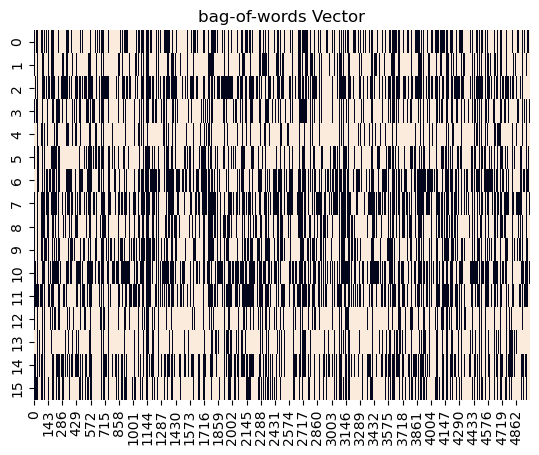

interactive(children=(Dropdown(description='cat', options=('A', 'B', 'D', 'F', 'H', 'K', 'L', 'N', 'P', 'R', '…

<function __main__.plot_explain_category(cat: str)>

In [21]:
from wordcloud import WordCloud

# Explain a category

lookup = [x for _,x in sorted(zip(text_vectorizer.vocabulary_.values(), text_vectorizer.vocabulary_.keys()))]
features_arr = np.array(text_vectorizer.get_feature_names())

def explain_bow_vector(vec: scipy.sparse.csr.csr_matrix, ax=plt):
    # _, idxs = scipy.sparse.csr_matrix.nonzero(vec)
    # words = [lookup[k] for k in idxs]
    # word_cloud = WordCloud().generate(' '.join(words))
    test = pd.DataFrame(vec.todense(), columns=features_arr).T.to_dict()[0]
    word_cloud = WordCloud(background_color="white").generate_from_frequencies(test)
    ax.imshow(word_cloud, interpolation='bilinear')
    ax.axis("off")

def explain_category(cat:str, ax=plt):
    target = list(mult_lbl_enc.classes_).index(cat)
    target = description_vec[target]
    explain_bow_vector(target, ax=ax)

def plot_explain_category(cat:str):
    explain_category(cat)

interact(plot_explain_category, cat=mult_lbl_enc.classes_)

In [22]:
key = 'transcript__conversation_both'
# key = 'transcript__conversation_gp'
# key = 'transcript__conversation_patient'

X_train = text_vectorizer.transform(train_set[key])
X_test = text_vectorizer.transform(test_set[key])

In [23]:
# import seaborn as sns
sns.heatmap(X_train.todense()==0, vmin=0, vmax=1, cbar=False).set_title('Train set bag-of-words matrix')

Text(0.5, 1.0, 'Train set bag-of-words matrix')

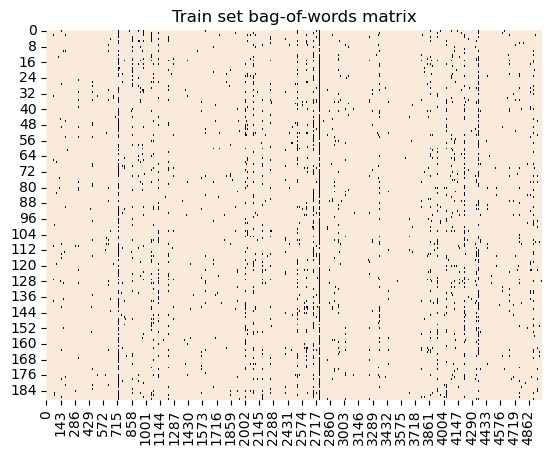

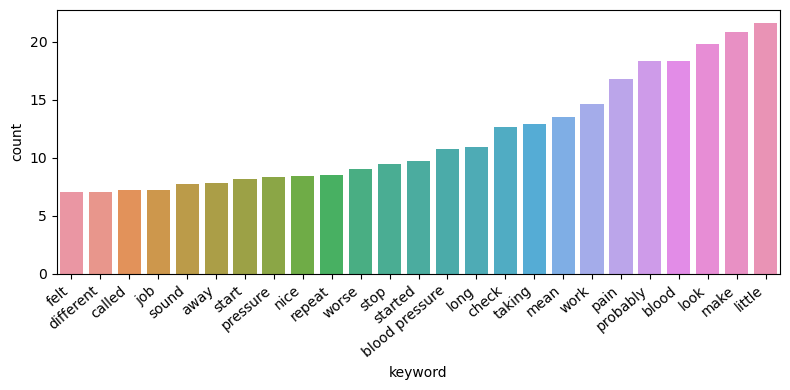

['felt', 'different', 'called', 'job', 'sound', 'away', 'start', 'pressure', 'nice', 'repeat', 'worse', 'stop', 'started', 'blood pressure', 'long', 'check', 'taking', 'mean', 'work', 'pain', 'probably', 'blood', 'look', 'make', 'little']


In [24]:
keyword_dist_over_train = np.array(X_train.sum(axis=0)).flatten()

def show_common_keywords(threshold:int = 7):
    frequent_words = [[k,n] for k,n in zip(lookup, keyword_dist_over_train) if n > threshold]
    frequent_words_df = pd.DataFrame(frequent_words,columns=['keyword', 'count']).sort_values('count')

    plt.figure(figsize=(8,4))
    ax = sns.barplot(x='keyword', y='count', data=frequent_words_df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

    print([k._text for k in ax.get_xticklabels()])

show_common_keywords()

### Nearest Centroid classifier

In [25]:
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier

kn_clf = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='cosine')
kn_clf.fit(description_vec, mult_lbl_enc.classes_)

nc_clf = NearestCentroid(metric='cosine')
nc_clf.fit(description_vec, mult_lbl_enc.classes_)

C:\Users\dotvi\anaconda3\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:150: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "


NearestCentroid(metric='cosine')

In [26]:
mult_lbl_enc.inverse_transform(y_train[0:1])

[('K', 'P')]

In [27]:
kn_clf.predict_proba(X_train[0:10])

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.337287  , 0.32459249, 0.        , 0.33812052, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.37978207, 0.31186165, 0.30835628, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.33064004, 0.33187647, 0.        , 0.        ,
        0.3374835 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.31551275, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.34390836, 0.        , 0.        , 0.34057889,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.33511534, 0.        ,
        0.        , 0.        , 

In [28]:
kn_y_pred = kn_clf.predict(X_train)
y_pred = nc_clf.predict(X_train)

In [29]:
def get_idxes_with_cat(_y_train: np.ndarray, code:str):
    y_train_raw = mult_lbl_enc.inverse_transform(_y_train)
    return [i for i,cs in enumerate(y_train_raw) if code in cs]

def get_truth_pred_pairs(_y_train, _y_pred, indices):
    truth = mult_lbl_enc.inverse_transform(_y_train[indices])
    pred = _y_pred[indices]
    data = list(zip(indices, truth, pred))
    return pd.DataFrame(data, columns=['id', 'truth', 'predicted'])

def show_truth_pred_tbl(code):
    cat_idxes = get_idxes_with_cat(y_train, code)
    return get_truth_pred_pairs(y_train, y_pred, cat_idxes)

interact(show_truth_pred_tbl, code=mult_lbl_enc.classes_)

interactive(children=(Dropdown(description='code', options=('A', 'B', 'D', 'F', 'H', 'K', 'L', 'N', 'P', 'R', …

<function __main__.show_truth_pred_tbl(code)>

Seems like the baseline is not performing well on predicting classes for:

A, F, N, S, T, W, X, Y

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

cat_dropdown = widgets.Dropdown(options=mult_lbl_enc.classes_)
id_dropdown = widgets.Dropdown(options=get_idxes_with_cat(y_train, cat_dropdown.value))

def refresh_id_dropdown(*args):
    id_dropdown.options = get_idxes_with_cat(y_train, cat_dropdown.value)

cat_dropdown.observe(refresh_id_dropdown, 'value')

def show_cosine_similarity(_id):
    cos_sim = cosine_similarity(X_train[_id], description_vec)[0]
    cos_sim = pd.DataFrame(list(zip(mult_lbl_enc.classes_, cos_sim)), columns=['category', 'cos sim'])
    cos_sim = cos_sim.set_index('category').T
    grid_kws = {"height_ratios": (.9, .05), "hspace": -0.5}
    f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
    sns.heatmap(cos_sim, square=True, ax=ax,
                cbar_ax=cbar_ax,
                cbar_kws={"orientation": "horizontal"},
                cmap='Greens')

def show_keywords_true_pred(_id):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.title.set_text('BOW from sample transcipt')
    ax2.title.set_text('BOW of predicted class')
    explain_bow_vector(X_train[_id], ax=ax1)
    explain_category(y_pred[_id], ax=ax2)

def view_record(_cat, _id):
    global test
    record = train_set.iloc[_id]
    info = [f"Index: {_id}",
           f"Id: {record['record_id']}",
           f"Actual: {mult_lbl_enc.inverse_transform(y_train[_id:_id+1])}",
           f"Predicted: {y_pred[_id]}"]
    display(*info)
    show_keywords_true_pred(_id)
    show_cosine_similarity(_id)

interact(view_record, _cat=cat_dropdown, _id=id_dropdown)

interactive(children=(Dropdown(description='_cat', options=('A', 'B', 'D', 'F', 'H', 'K', 'L', 'N', 'P', 'R', …

<function __main__.view_record(_cat, _id)>

In [31]:
y_train_mat = np.matrix(y_train)
y_pred_mat = np.matrix(mult_lbl_enc.transform(y_pred))


In [32]:
# Note: print statements does not work in PyCharm

from sklearn.metrics import accuracy_score, classification_report, f1_score, multilabel_confusion_matrix, precision_recall_fscore_support, roc_auc_score

print(f"classification_report:\n{classification_report(y_train_mat, y_pred_mat, target_names=mult_lbl_enc.classes_)}")

print(f"multilabel_confusion_matrix:")
conf_mat = multilabel_confusion_matrix(y_train_mat, y_pred_mat)

for cls, mat in zip(mult_lbl_enc.classes_, conf_mat):
    fig = plt.figure(figsize=(1,1))
    ax = fig.add_subplot()
    ax.set_title(cls)
    sns.heatmap(mat, ax=ax, cmap='Blues', annot=True, fmt="d")
    ax.set_xlabel('pred')
    ax.set_ylabel('true')
    fig.show()

C:\Users\dotvi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-32-df4e90993586>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


classification_report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        14
           B       1.00      0.33      0.50         6
           D       0.79      0.37      0.50        30
           F       0.00      0.00      0.00         3
           H       1.00      0.88      0.93         8
           K       0.41      0.68      0.51        22
           L       0.64      0.75      0.69        52
           N       0.17      0.10      0.12        10
           P       0.81      0.45      0.58        38
           R       0.88      0.56      0.68        27
           S       1.00      0.35      0.52        23
           T       0.57      0.29      0.38        14
           U       0.67      0.12      0.21        16
           W       1.00      0.10      0.18        10
           X       1.00      0.11      0.20         9
           Y       0.00      0.00      0.00         6

   micro avg       0.65      0.43      0.52       288
   

For `average` parameter to take the average metrics over all classes, please see [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel).

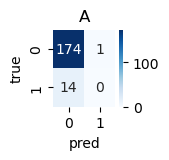

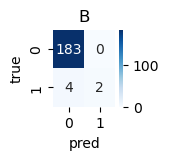

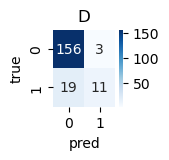

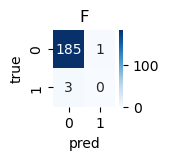

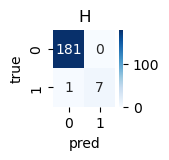

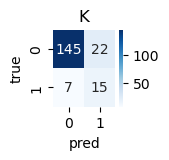

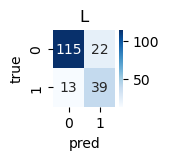

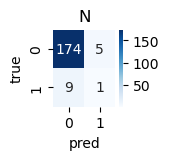

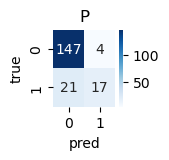

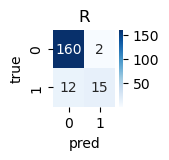

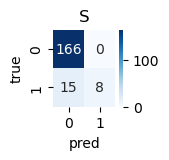

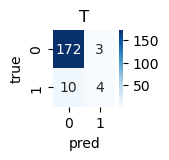

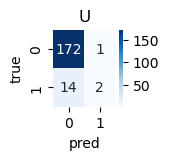

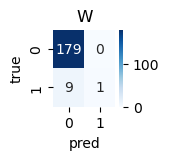

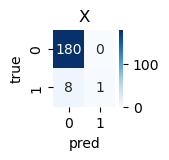

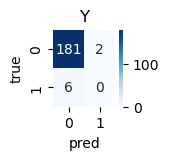

interactive(children=(Dropdown(description='average', index=1, options=('macro', 'weighted', 'micro', 'samples…

<function __main__.show_result(average='weighted')>

In [33]:

def show_result(average='weighted'):
    # measures the subset accuracy (only considered as accurate if the whole set matches)
    print(f"accuracy score: {accuracy_score(y_train_mat, y_pred_mat)}")

    print(f"f1_score: {f1_score(y_train_mat, y_pred_mat, average=average)}")

    print(f"precision_recall_fscore_support:\n{precision_recall_fscore_support(y_train_mat, y_pred_mat, average=average)}")

    print(f"roc_auc_score: {roc_auc_score(y_train_mat, y_pred_mat, average=average)}")

interact(show_result, average=['macro', 'weighted', 'micro', 'samples'])